## Transformer

- http://nlp.seas.harvard.edu/2018/04/03/attention.html
- http://jalammar.github.io/illustrated-transformer/

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context='talk')
%matplotlib inline

## 模型架构

Transformer模型架构主要处理自然语言处理相关的工作，因此很多命名方式遵循NLP中的规则，比如Embedding层将称作**文本嵌入层**，Embedding层产生的张量称为**词嵌入张量**，它的最后一维将称作**词向量**。

通用的 **编码器解码器** 架构：
       
<img src="../images/Transformer.png" width="40%">

**输入部分包括**：

1. 源文本的嵌入层及其位置编码器。源文本先进入一个Embedding嵌入层，之后紧接着进入一个位置编码器的处理。
2. 目标文本嵌入层及其位置编码器。目标文本也先进入一个Embedding嵌入层，之后也经过一个位置编码器。

**输出部分**：就是一个线性层和一个Softmax输出概率：

**编码器部分**：

1. 由N个编码器堆叠而成，每个编码器层由两个子层连接结构组成。
2. 第一个子层连接结构包括一个多头注意力子层和规范化层以及一个残差连接。
3. 第二个子层连接结构包括一个前馈全连接子层和规范化层以及一个残差连接。

**解码器部分**：

1. 由N个解码器堆叠而成，每个解码器层由三个子层连接结构组成，
2. 第一个子层连接结构包括一个多头自注意力子层和规范化层以及一个残差连接。
3. 第二个子层连接结构包括多头注意力子层和规范化层以及一个残差连接。
4. 第三个子层连接结构包括一个前馈全连接子层和规范化层以及一个残差连接。



## 1. 嵌入层

文本嵌入层的作用，无论是源文本嵌入还是目标文本嵌入，都是为了将文本中词汇的数字表示转变为向量表示，希望在这样的高纬空间中捕捉词汇间的关系。

In [2]:
# 这里Embeddings中的s表示两个一模一样的嵌入层，他们共享参数。
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        """
        # d_model: 指词嵌入的维度。
        # vocab: 指词表的大小。如果是英译法，那英文的词表大小就是源文本词表大小，法文词表大小为目标词表大小。
        """
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        """
        # 参数x: 因为词嵌入是首层，所以代表输入给模型的文本通过词汇映射后的张量。
        """
        return self.lut(x) * math.sqrt(self.d_model) # math.sqrt(self.d_model)其缩放的作用

- nn.Embedding的演示:

In [3]:
embedding = nn.Embedding(10, 3)
input_word = torch.LongTensor([[1,2,4,1],[4,3,2,9]])
print(embedding(input_word))

tensor([[[-0.1039, -1.1569,  0.0337],
         [ 0.1868,  1.7118,  0.3037],
         [-0.5534,  0.7778, -0.0221],
         [-0.1039, -1.1569,  0.0337]],

        [[-0.5534,  0.7778, -0.0221],
         [ 0.7531, -0.7355, -0.0062],
         [ 0.1868,  1.7118,  0.3037],
         [ 0.1565,  0.4716, -0.9841]]], grad_fn=<EmbeddingBackward>)


## 2. 位置编码

因为在`Transformer`的编码结构中，并没有针对词汇位置信息的处理，因此需要在`Embedding`层后加入位置编码，将词汇位置不同可能会产生不同语意的信息加入到词嵌入张量中，以弥补位置信息的缺失。

$$
\text{PE}(i,\delta) = 
\begin{cases}
\sin(\frac{i}{10000^{2\delta'/d}}) & \text{if } \delta = 2\delta'\\
\cos(\frac{i}{10000^{2\delta'/d}}) & \text{if } \delta = 2\delta' + 1\\
\end{cases}
$$



In [4]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        """
        # d_model: 词嵌入的维度；dropout: 置0比率；max_len: 每个句子的最大长度。
        """
        super(PositionalEncoding, self).__init__()
        # 实例化nn中预定义的Dropout层，并将dropout传入其中。
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)  # 初始化一个位置编码矩阵，它是一个0矩阵，矩阵的大小是[max_len, d_model]
        # 初始化一个绝对位置矩阵，在这里，词汇的绝对位置就是用它的索引去表示
        position = torch.arange(0, max_len).unsqueeze(1)  # shape=(max_len, 1)

        # 绝对位置矩阵初始化后，接下来就是考虑如何将这些位置信息加入到位置编码矩阵中。
        # 最简单的思路就是将 max_len x 1的绝对位置矩阵，变换成 max_len x d_model 形状，然后覆盖初始矩阵即可。
        # 要做这种矩阵变换，就需要一个 1 x d_model 形状的变换矩阵 div_term。
        # 我们还希望它能够将自然数的绝对位置编码缩放成足够小的数字，有助于之后的梯度下降过程中更快的收敛。
        # 首先使用arange获得一个自然数矩阵，但是这里我们并没有按照预计的那样初始化一个(1 x d_model)的矩阵
        # 我们可以把它看作是初始化了两次，而每次初始化的变换矩阵会做不同的处理，第一次初始化的变换在正弦波上，第二次余弦波上。
        # 并把这两个矩阵分别填充在位置编码的偶数和奇数位置上，组成最终的位置编码矩阵。
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)) # shape=(1, d_model/2)
        
        pe[:, 0::2] = torch.sin(position * div_term) # shape = [max_len, d_model] 偶数项用sin
        pe[:, 1::2] = torch.cos(position * div_term) # shape = [max_len, d_model] 奇数项用cos

        
        # 这样，我们就得道理一个位置编码矩阵pe，pe现在还只是一个二维矩阵，想要和embedding的输出(一个三维矩阵)相加
        # 就必须扩展一个维度，所以这里使用unsequeeze扩展维度
        pe = pe.unsqueeze(0)
        
        # 最后把pe位置编码矩阵注册成模型buffer，什么是buffer。
        # 我们可以把它们认为是对模型有帮助的，但是却不是模型结构中的超参数，不需要随着优化步骤进行更新的增益对象
        # 注册之后我们就可以在模型保存后重加载时和模型结构与参数一同被加载。
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        # forward函数的参数是x，表示文本序列的词嵌入表示。
        # 在相加之前，我们对pre做一些适配工作，将这个三维张量的第二维也就是句子最大长度的那一维，切片与输入的x的第二维相同即可。
        # 因为我们默认max_len为5000一般来讲实在太大了，很难有一条句子包含5000个词汇，所以需要进行与输入张量的适配。
        # 最后使用Variable进行封装，使其与x的样式相同，但是它不需要进行梯度求解，所以requires_grad设置为false。
        """
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        # 最后使用dropout对象进行丢弃操作，并返回结果。
        return self.dropout(x)

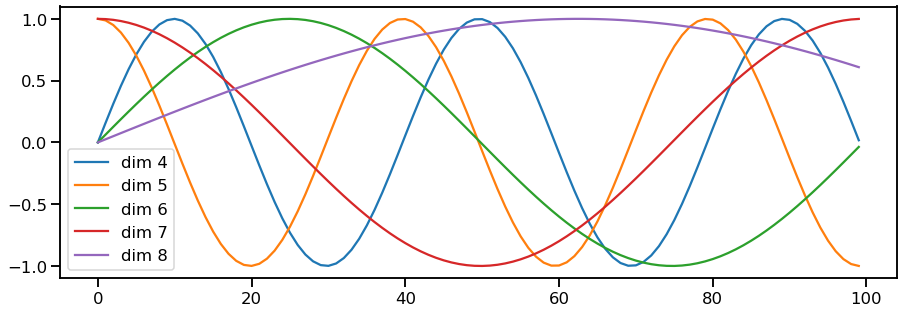

In [5]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20))) # shape = (batch_size, seq_len, d_word)
plt.plot(np.arange(100), y[0, :, 4:9].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7,8]])

Transformer虽然摒弃了RNN的循环结构和CNN的局部相关性，但对于序列来说，最重要的还是先后顺序。于是需要为词嵌入后的张量的每个元素添加位置信息。每个元素的位置有两个含义：

- 每个词向量在句子中所处的时间步(axis=1),记为pos。
- 词向量内每个元素所处的向量维度(axis=2),记为j。

位置编码与Batch无关，不同batch相同位置的元素对应的位置编码信息相同。

## 3. 编码器

编码器由多层 `N=6` 完全相同的层堆叠而成
<img src="../images/Transformer-encoder.png" width="40%">
其层次结构如上图中所示：
```
1. Encoder
    2. EncoderLayer
        3. SublayerConnection
            4. sublayer --> self_attn
            
        3. SublayerConnection
            4. sublayer --> feed_forward
            
    2. EncoderLayer
    .
    .
    .
    .
```

### 3.1 掩码张量

掩码表示遮掩，它的尺寸不定，里面一般只有两种`1`和`0`两种元素，代表位置被遮掩，或者不被遮掩，至于是`0`位置被遮掩还是`1`位置被遮掩可以自定义。因此它的作用就是让另一个张量中的一些数值被遮掩，也可以说被替换，它的表现形式是一个张量。

在`transformer`中，掩码张量的主要作用是应用在`attention`中，有一些生成的`attention`张量中的值计算有可能已知了未来信息而得到的，未来信息被看到是因为训练时会把整个输出结果都一次性进行Embedding，但是理论上解码器的输出却不是一次就能产生最终结果的，而是一次次通过上一次结果综合得出的，因此，未来的信息可能被提前利用，所以需要遮掩。

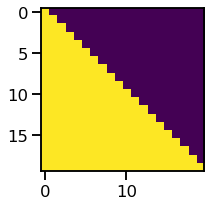

In [6]:
def subsequent_mask(size):
    """
    # 解码器一次输入序列中向量，当前步后面的序列需要被遮盖, 参数size是掩码张量最后两个维度的大小，它的最后两维形成一个方阵。
    # 需要被遮盖的单词被标记为 False 
    """
    attn_shape = (1, size, size)
    # np.ones往矩阵里面添加1，然后使用np.triu形成上三角矩阵，使用'uint8'节省空间开销。
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0 # 取衡等于0的，使其变为下三角矩阵。

plt.figure(figsize=(3, 3))
plt.imshow(subsequent_mask(20)[0])

`np.triu(m,k=0)`：第 k 对角线以下的元素归零，中心对角线索引为 0 ，索引向右上角增加 1、2、3 ，向左下角-1、-2、-3
```
>>> np.triu([[1,2,3],[4,5,6],[7,8,9],[10,11,12]], -1)
array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 0,  8,  9],
       [ 0,  0, 12]])
```

在翻译过程中，每次送入解码器的句子只包含已经翻译出来的那些词，而不包含还没有翻译出来的未来的词。为了使训练和测试保持一致，解码器端在训练的时候也需要遮盖掉未来的词。即：**当前时间步只能看到该时间步之前输入的所有词**。

### 3.2 注意力机制

注意力机制需要指定三个输入$Q$，$K$，$V$，然后通过公式得到注意力的计算结果。这个结果代表`query`在`key`和`value`作用下的表示，而这个具体的计算规则有很多种，我这里只介绍我们用到的这一种：

<img src="../images/scaled_attention.png" width="30%">


$$\mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V$$

假如我们有一个问题：给出了一段文本，使用一些关键词对它进行描述！为了方便统一正确答案，这道题可能预先已经给大家写出了一些关键词作为提示，其中这些给出的提示就可以看作是`key`，而整个文本的信息就相当于`query`，`value`的含义则更抽象，可以比作是看完这段文本信息后，脑子里浮现的答案信息，假设我们一开始并不是很聪敏，第一次看到这段文本后脑子里基本上浮现的信息就只有提示信息。因此`key`和`value`基本是相同的，但是随着我们对这个问题的深入理解，开始能够对`query`的关键信息进行提取关键信息，根据提示`key`生成`query`的关键词表示方法，也就是另外一种特征表示方法。

刚刚我们说到`key`和`value`一般情况下是相同的，与`query`是不同的，但是自注意力机制中`query`、`key`和`value`是相同的。自注意力机制需要用给定文本自身来表达自己，也就是需要从给定文本中抽取关键词来表述它，相当于对文本自身的一次特征提取。

In [7]:
def attention(query, key, value, mask=None, dropout=None):
    """
    query : batch, target_len, feats
    key   : batch, seq_len,    feats
    value : batch, seq_len,    val_feats
    
    return: batch, target_len, val_feats
    """
    # 在函数中，首先取query的最后一个维度的大小，一般情况下就等同于我们的词嵌入维度，命名为d_k。
    d_k = query.size(-1)
    
    # 按照注意力公式，将query与key的转置相乘，这里面key是将最后两个维度进行转置，再除以缩放系数，得到注意力张量得分。
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    
    # 接着判断mask是否使用掩码张量。
    if mask is not None:
        # 使用tensor的masked_fill方法将掩码张量每个位置一一比较，如果掩码张量为0，用-1e9填充。
        scores = scores.masked_fill(mask == 0, -1e9)
    
    # 对score的最后一个维度进行softmax操作，得到注意力张量。
    p_attn = F.softmax(scores, dim=-1)

    if dropout is not None:
        p_attn = dropout(p_attn)
    # 最后根据公式，将p_attn与value张量相乘，获得最终的query注意力表示。
    return torch.matmul(p_attn, value), p_attn

In [8]:
def test_attention():
    query = torch.randn(3, 5, 4)  # batch, target_len, feats
    key = torch.randn(3, 6, 4)  # batch, seq_len, feats
    value = torch.randn(3, 6, 8)  # batch, seq_len, val_feats
    attn, p_attn = attention(query, key, value)
    print("attn.shape: ", attn.shape)
    print("p_attn.shape: ", p_attn.shape)
    assert attn.shape == (3, 5, 8)
    print("Test passed")

# 如果query=key=value，我们将其称为自注意力机制。
test_attention()

attn.shape:  torch.Size([3, 5, 8])
p_attn.shape:  torch.Size([3, 5, 6])
Test passed


### 3.3 多头注意力机制


<img src="../images/multi_head_attention.png" width="40%">

从多头注意力的结构图中，貌似这个所谓的多个头就是指多组线性变换层，其实并不是。我只有使用了一组线性变化层，即三个变换张量对Q、K、V分别进行线性变换，这些变换并不会改变原有张量的尺寸，因此**每个变换矩阵都是方阵**，得到输出结果后，多头的作用才开始显现，每个头开始从词义层面分割输出张量，也就是**每个头都想获得一组独立的Q、K、V进行注意力机制的计算**，但是句子中的每个词表示只获得一部分，也就是只分割最后一维的词嵌入向量，这就是所谓的多头，将每个头的获得的输入送到注意力机制中，就形成多头注意力机制。

这种结构设计能让每个注意力机制去优化每个词汇的不同特征部分，从而均衡同一种注意力机制可能产生的偏差，让词义拥有来自更多元的表达，实验表明可以从而提升模型效果。

In [9]:
# 首先需要定义克隆函数，因为在多头注意力机制的实现中，用到多个结构相同的线性层。
# 所以我们定义一个可以复制多份网络的函数：
def clone(module, N):
    """
    # 克隆网络的函数，它的参数module表示要克隆的目标网络层，N代表需要克隆的数量。
    # 然后在函数中，我们通过for循环对module进行N次深度拷贝，使其每个module成为独立的层，然后将其放在nn.ModuleList类型的列表中存放。
    # 然后将其放在nn.ModuleList中存放。
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [10]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        """
        h, num_heads 代表头数。
        d_model, features 代表词嵌入的维度。
        """
        super(MultiHeadedAttention, self).__init__()
        # 在函数中，首先判断h是否能够被d_model整除，这是因为我们之后要给每个头分配等量的词特征，也就是d_model/h个。
        assert d_model % h == 0
        
        self.d_k = d_model // h  # 得到每个头获得的分割词向量维度d_k。
        self.h = h  # 传入头的数量
        
        # 然后获得线性层对象，通过nn.Linear实例化，它的内部变换矩阵是d_model x d_model, 然后使用clones函数复制4份
        # 这是因为在多头注意力机制中，Q、K、V各需要一个，最后拼接的矩阵还需要一个，因此是四个。
        self.linears = clone(nn.Linear(d_model, d_model), 4)
        self.attn = None  # 代表注意力张量，初始赋值为None。
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        # query,key,value: batch,seq_len,d_model
        
        if mask is not None:
            mask = mask.unsqueeze(1) # 使用unsqueeze扩展维度，代表多头中的第n个头。
            
        # 接着，我们获得一个batch_size的变量，他是query尺寸的第一个数字，代表有多少条样本。
        nbatches = query.size(0)
        
        # 首先利用zip将输入的QKV与三个线性层组到一起，然后使用for循环，将输入QKV分别传到线性层中。
        # self.linears中有四个线性层，只传入3个的话，只会处理前面三个。
        # 拿到网络结构和数据之后，我们用view对数据做维度转换。
        # 为了让代表句子长度维度和词向量维度能够相邻，这样注意力机制才能找到词义与句子之间的位置关系。
        # 从attention函数中，可以看到，利用的是原始输入的倒数第一维和倒数第二维，这样我们就得到了每个头的输入。
        query, key, value = [
            l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for l, x in zip(self.linears, (query, key, value))
        ]
        
        # 直接调用attention函数，同时也将mask和dropout传入其中。
        x, self.attn = attention(
            query,  # batch,num_head,seq_len,feats
            key,
            value,
            mask=mask,
            dropout=self.dropout)
        
        # 通过多头注意力计算后，我们就得到了每个头计算结果组成的4维张量，我们需要将其转换为输入的形状，以方便后续计算。
        # 因此这里开始进行第一步处理环节的逆操作，先对第二和第三维进行转置，然后使用contiguous方法。
        # 这个方法的作用就是能够让转置后的张量应用view方法，否则将无法直接使用。
        # 所以，下一步就是使用view重塑形状，变成输入形状相同。
        x = x.transpose(1, 2).contiguous().view(nbatches, -1,
                                                self.h * self.d_k)
        # batch,seq_len,num_head*feats
        return self.linears[-1](x)  # 最后使用线性层列表中的最后一个线性层对输入进行线性变换。得到最终的多头注意力结构的输出。

In [11]:
def test_multi_head():
    x = torch.randn(2, 4, 12)
    d_model = x.shape[-1]
    model = MultiHeadedAttention(2, d_model)
    attn = model(x, x, x)
    assert attn.shape == (2, 4, 12)
    print("Test passed!")

test_multi_head()

Test passed!


### 3.4 前馈全连接层

在`Transformer`中，前馈全连接层就是具有两层线性层的全连接网络。是考虑注意力机制可能对于复杂过程的拟合程度不够，通过增加两层网络来增强模型的能力：

In [12]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        """
        d_model: 词嵌入的维度
        d_ff: dff表示前馈全连接层中间输入的维度，也就是隐藏层维度。
        """
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

### 3.5 规范化层

规范化层是所有深层网络模型都需要的标准网络层，因为随着网络层数的增加，通过多层的计算后，参数可能开始出现过大或者过小的情况，这样可能会导致学习过程出现异常，模型可能收敛非常慢。因此都会在一定层数后接规范化层进行数值的规范化，使其特征数在合理范围内。

- Batch Normalization

BN是按照样本数计算归一化统计量的，当样本数很少时，比如说只有4个。这四个样本的均值和方差便不能反映全局的统计分布息，所以基于少量样本的BN的效果会变得很差。

BN是取不同样本的**同一个通道**的特征做归一化；LN则取的是**同一个样本**的不同通道做归一化。

- Layer Normalization

LN相当于是对特征做归一化。

In [13]:
class LayerNorm(nn.Module):
    """
    inputs: batch, seq_len, features
    沿输入数据的特征维度归一化
    """
    def __init__(self, features, eps=1e-6):
        # 需要指定特征数量 features, 表示词嵌入的维度。
        super(LayerNorm, self).__init__()
        
        # 根据features的形状初始化两个参数张量a2和b2，第一个初始化为1张量，第二个初始化为0张量。这两个张量就是规范化公式
        # 因为直接对上一层得到的结果做规范化公式计算，将改变结果的正常表征，因此就需要有参数作为调节因子。
        # 使其既能满足规范化要求，又能不改变针对目标的表征，最后使用nn.Parameter封装，代表他们是模型的参数。
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))  # 参数，之后也要学习。
        self.eps = eps  # 防止除0

    def forward(self, x):
        """
        x --> (x - x.mean) / x.std 
        """
        mean = x.mean(-1, keepdim=True) # 在最后一个维度求均值，保持维度不变。
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [14]:
def test_layernorm():
    x = np.array([[[1, 2, 3], [2, 4, 5]],], dtype=np.float)  # shape = (1, 2, 3)
    print("Before Norm: \n", x)
    x = torch.from_numpy(x)       # batch, seq_len, features
    norm = LayerNorm(x.shape[-1])
    x = norm(x)
    print("After Norm: \n", x.detach().numpy())

test_layernorm()

Before Norm: 
 [[[1. 2. 3.]
  [2. 4. 5.]]]
After Norm: 
 [[[-0.999999    0.          0.999999  ]
  [-1.09108874  0.21821775  0.87287099]]]


/var/folders/x9/xgj8n5xd2bb0cv55w7c72bn40000gn/T/ipykernel_7542/1527541485.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array([[[1, 2, 3], [2, 4, 5]],], dtype=np.float)  # shape = (1, 2, 3)


### 3.6 子层连接结构

输入到每个子层以及规范化层的过程中，还使用了残差连接(跳跃连接)，因此我们把这一部分结构整体叫做子层连接(代表子层及其连接结构)，在每个编码器层中，都有两个子层，这两个子层加上周围的连接结构就形成了两个子层连接结构：

`SublayerConnection`中，将`sublayer`、`LayerNorm`、`Dropout`连接在一起。其中`sublayer`为我们指定的神经网络结构，可以为全连接或者是`Attention`。

`SublayerConnection`层中，输入先经过一个`Layer Normalization`，然后再经过一个指定的`sublayer`，再经过一个`dropout`，并连接一个残差：

In [15]:
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        # 实例化了规范化对象self.norm。
        self.norm = LayerNorm(size)
        # 又使用nn中预定义的dropout实例化一个self.dropout对象。
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, sublayer):
        """
        指定内部的结构 sublayer，是 attention 层，还是 feed_forward 层
        """
        # 首先对输出进行规范化，然后将结果传给子层处理，之后再对子层进行dropout操作。
        # 随机停止一些网络中神经元的作用，来防止过拟合，最后还有一个add操作。
        # 因为存在跳跃连接，所以是将输入x与dropout后的子层输出结果相加作为最终的子层连接输出。
        return x + self.dropout(sublayer(self.norm(x)))

在整个的`EncoderLayer`层的`SublayerConnection`中，我们需要去连接一个注意力机制和一个前馈神经网络：

### 3.7 编码器层

作为编码器的组成单元，每个编码器完成一次对输入特征的提取过程，即编码过程：

In [16]:
class EncoderLayer(nn.Module):
    """size: d_model"""
    def __init__(self, size, self_attn, feed_forward, dropout):
        """
        # size就是我们词嵌入的维度的大小，self_attn为多头自注意力子层实例化对象，feed_forward是我们传入前馈全连接层实例化对象。
        """
        super(EncoderLayer, self).__init__()
        # 首先将self_attn和feed_forward传入其中。
        self.self_attn = self_attn
        self.sublayer = clone(SublayerConnection(size, dropout), 2)
        # 如图所示，编码器层中有两个子层连接结构，所以使用clone函数进行克隆。
        self.feed_forward = feed_forward
        # 把size传入其中。
        self.size = size

    def forward(self, x, mask):
        """
        # 里面就是按照结构图左侧的流程，首先通过一个子层连接结构，其中包含多头自注意力子层。
        # 然后通过第二个子层连接结构，其中包含前馈全连接子层，最后返回结果。
        """
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

### 3.8 编码器

编码器用于对输入进行指定的特征提取过程，也称为编码，由N个编码器层堆叠而成。

In [17]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clone(layer, N)  # 将多头注意力和前馈网络复制N份
        self.norm = LayerNorm(layer.size)  # 最后输出的时候接一个Layer Normalization层

    def forward(self, x, mask):
        """
        需要自主生成 mask 
        """
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

## 4. 解码器

<img src="../images/Transformer-decoder.png" width="40%">

### 4.1 解码器层

解码器层中的各个部分，如多头注意力机制，规范化层，前馈全连接网络，子层连接结构都与编码器中的实现相同，因此这里可以直接拿过来构建解码器层。

作为解码器的组成单元，每个解码器层根据给定的输入向目标方向进行特征提取操作，即解码过程。

In [18]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        """
        size表示词嵌入的维度大小，同时也代表解码器的尺寸。第二个是多头自注意力对象。Q=K=V。
        第三个是src_attn多头注意力对象Q！=K=V。
        第四个是前馈全连接层对象。
        """
        super(DecoderLayer, self).__init__()
        self.size = size  # 作为参数用于 layernorm 层
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        
        # 克隆三个子层连接对象
        self.sublayer = clone(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        """
        上一层的输入x，来自编码器层的语意存储变量memory，以及源数据掩码张量和目标数据掩码张量。
        """
        m = memory
        # 将x传入第一个子层结构，第一个子层结构的输入分别是x和self-atten函数，因为是自注意力机制。
        # 最后一个参数是目标数据掩码张量，这时要对目标数据进行遮掩，因为此时模型可能还没有生成任何目标数据。
        # 比如在解码器准备生成第一个字符或词汇时，我们其实已经传入了第一个字符以便计算损失。
        # 但是我们不希望在生成第一个字符时，模型能利用这个信息，因此我们常常会将其遮掩，同样生成第二个字符或词汇时。
        # 模型只能使用第一个字符或词汇信息，第二个字符以及之后的信息都不允许被模型使用。
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        
        # 接着进入第二个子层，这个子层中常规的注意力机制，q是输入x；k，v是编码输出memory。
        # 同样也传入source_mask，但是进行源数据遮掩的原因并非是抑制信息泄漏，而是遮蔽掉对结果没有意义的字符而产生的注意力值。
        # 以此提升模型的效果和训练速度，这样就完成了第二个子层的连接。
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

### 4.2 解码器

In [19]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        """
        layer: 表示的就是解码器层，N表示解码器层的个数。
        """
        super(Decoder, self).__init__()
        self.layers = clone(layer, N)  # 克隆N个layer，然后实例化一个规范化层。因为数据走过了所有的解码器层后最后要做规范化处理。
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        """
        forward中的参数有4个，x代表目标数据的嵌入表示，memory是编码器层的输出。
        """
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

## 5. 整体框架
定义一个`Encoder`和`Decoder`的基类：

In [20]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        """
        编码器、解码器、输入嵌入层、目标嵌入层、输出层
        """
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed  # 源目标文本编码
        self.tgt_embed = tgt_embed  # 目标文本编码
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        """
        src --> memory
        memory + tgt --> output
        """
        memory = self.encode(src, src_mask)
        return self.decode(memory, src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        """
        src --> memory
        """
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        """
        memory + tgt --> output
        """
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

可以看到上述的这个编码解网络架构，有六个网络的输入：**编码器**、**解码器**、**输入嵌入层**、**目标嵌入层**、**输出层**。

解码器之后要接一个输出层，主要功能是做一个`Softmax`的归一化：

In [21]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."

    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

## 6. 完整的模型 

In [22]:
def make_model(src_vocab,
               tgt_vocab,
               N=6,
               d_model=512,
               d_ff=2048,
               h=8,
               dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    """
    src_vocab: 源数据特征（词汇）总数，目标数据特征（词汇）总数。
    # 编码器和解码器堆叠数，词向量映射维度，前馈全连接网络中变换矩阵的维度。
    # 多头注意力结构中的多头数，以及置0比率。
    """
    
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    
    # 根据结构图，最外层是EncoderDecoder，在EncoderDecoder中，
    # 分别是编码器层，解码器层，源数据Embedding层和位置编码组成的有序结构。
    # 目标数据Embedding层和位置编码组成的有序结构，以及类别生成器层。
    # 在编码器层中有attention子层以及前馈全连接子层
    # 在解码器层中有两个attention子层以及前馈全连接层。
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab),
    )

    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [23]:
tmp_model = make_model(10, 10, 2)
tmp_model

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=5

In [24]:
tmp_model.src_embed

Sequential(
  (0): Embeddings(
    (lut): Embedding(10, 512)
  )
  (1): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

## 数据批次，同时创建 mask

In [25]:
class Batch:
    def __init__(self, src, trg=None, pad=0):
        """
        src: 输入序列
        trg: 目标序列
        """
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        """
        将 pad 产生的 mask，和序列一次预测下一个单词产生的 mask 结合起来
        """
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [26]:
src = torch.tensor([[3, 5, 7, 0, 0], [2, 4, 6, 8, 0]])  # batch=2,seq_len=5
trg = torch.tensor([[2, 3, 4, 5, 0, 0], [3, 5, 6, 0, 0,
                                         0]])  # batch=2,seq_len=6

sample = Batch(src, trg)
sample.src_mask

tensor([[[ True,  True,  True, False, False]],

        [[ True,  True,  True,  True, False]]])

In [27]:
sample.trg_mask, sample.ntokens

(tensor([[[ True, False, False, False, False],
          [ True,  True, False, False, False],
          [ True,  True,  True, False, False],
          [ True,  True,  True,  True, False],
          [ True,  True,  True,  True, False]],
 
         [[ True, False, False, False, False],
          [ True,  True, False, False, False],
          [ True,  True,  True, False, False],
          [ True,  True,  True, False, False],
          [ True,  True,  True, False, False]]]),
 tensor(5))

## 训练过程

In [28]:
def run_epoch(data_iter, model, loss_compute):
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, batch.src_mask,
                            batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens  # 总 tokens 数
        tokens += batch.ntokens  # 50 批训练时的总 tokens 数
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                  (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

## 训练数据
 standard WMT 2014 English-German dataset consisting of about 4.5 million sentence pairs

In [29]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(mew, count, sofar):
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)   

## 优化器

Adam 优化器，参数$\beta_1=0.9$，$\beta_2=0.98$，$\epsilon=10^{-9}$，变学习率：

$$lrate = d_{\text{model}}^{-0.5} \cdot
  \min({step\_num}^{-0.5},
    {step\_num} \cdot {warmup\_steps}^{-1.5})$$
    
其中：    $warmup_{steps}=4000$

In [30]:
class NoamOpt:
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step=None):
        if step is None:
            step = self._step
        return self.factor * (self.model_size**(-0.5) *
                              min(step**(-0.5), step * self.warmup**(-1.5)))


def get_std_opt(model):
    return NoamOpt(
        model.src_embed[0].d_model, 2, 4000,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98),
                         eps=1e-9))

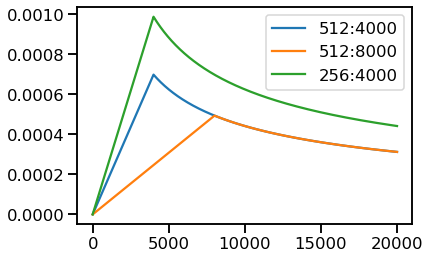

In [31]:
opts = [
    NoamOpt(512, 1, 4000, None),
    NoamOpt(512, 1, 8000, None),
    NoamOpt(256, 1, 4000, None),
]
plt.plot(np.arange(1, 20000),
         [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])

## 正则化
标签平滑`Label Smoothing`：$\epsilon_{ls}=0.1$，会降低 perplexity，因为模型将更不确定，但增加精度和`BLEU`分数

In [32]:
class LabelSmoothing(nn.Module):
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()

        true_dist.fill_(self.smoothing / (self.size - 2))
        
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

`nn.KLDivLoss`:
输入为`log`概率分布，目标为概率分布；$l(x,y) = L = \{ l_1,\dots,l_N \}, \quad l_n = y_n \cdot \left( \log y_n - x_n \right)$   
指定`reduction`参数时：
$$    \ell(x, y) = \begin{cases}
    \operatorname{mean}(L), & \text{if reduction} = \text{'mean';} \\
    \operatorname{sum}(L),  & \text{if reduction} = \text{'sum'.}
\end{cases}$$

`Tensor.scatter_(dim, index, src)`：
```
x = tensor([[0.1333, 0.1333, 0.1333, 0.1333, 0.1333],
            [0.1333, 0.1333, 0.1333, 0.1333, 0.1333],
            [0.1333, 0.1333, 0.1333, 0.1333, 0.1333]])       
index = tensor([[2],
                [1],
                [0]])
x.scatter(1, index, 0.6) -->
tensor([[0.1333, 0.1333, 0.6, 0.1333, 0.1333],
        [0.1333, 0.6, 0.1333, 0.1333, 0.1333],
        [0.6, 0.1333, 0.1333, 0.1333, 0.1333]]) 
    
```
例如上述的五分类中，目标序列 `[2，1，0]` 表示类别 2，1，0。将明确的类别转换成概率分布，使概率分布更均匀些，然后与预测概率分布求损失


/Users/tinyzqh/miniforge3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

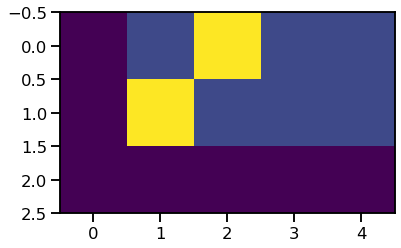

In [33]:
crit = LabelSmoothing(size=5, padding_idx=0, smoothing=0.4)
predict = torch.FloatTensor([
    [0, 0.2, 0.7, 0.1, 0],
    [0, 0.2, 0.7, 0.1, 0],
    [0, 0.2, 0.7, 0.1, 0],
])
v = crit(Variable(predict.log()), Variable(torch.LongTensor([2, 1, 0])))
plt.imshow(crit.true_dist)
crit.true_dist

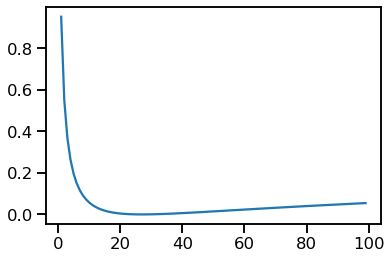

In [34]:
crit = LabelSmoothing(5, 0, 0.1)


def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([
        [0, x / d, 1 / d, 1 / d, 1 / d],  # 概率分布，x 的值越大，标签 1 的概率越大
    ])
    #print(predict)
    return crit(
        Variable(predict.log()),
        Variable(torch.LongTensor([1])),  # 真实标签为 1
    ).item()


plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])

## 测试模型

In [35]:
# 生成随机数据
def data_gen(V, batch, nbatches):
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

In [36]:
class SimpleLossCompute:
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator  # 模型最后的输出层
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data.item() * norm

In [37]:
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(
    model.src_embed[0].d_model, 1, 400,
    torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model,
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(
        run_epoch(data_gen(V, 30, 5), model,
                  SimpleLossCompute(model.generator, criterion, None)))

/Users/tinyzqh/miniforge3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch Step: 1 Loss: 3.187861 Tokens per Sec: 856.344849
Epoch Step: 1 Loss: 1.973794 Tokens per Sec: 1255.092773
tensor(2.0027)
Epoch Step: 1 Loss: 2.030267 Tokens per Sec: 954.758606
Epoch Step: 1 Loss: 1.780768 Tokens per Sec: 666.223328
tensor(1.7914)
Epoch Step: 1 Loss: 1.773943 Tokens per Sec: 640.631592
Epoch Step: 1 Loss: 1.364978 Tokens per Sec: 977.435852
tensor(1.3931)
Epoch Step: 1 Loss: 1.554691 Tokens per Sec: 935.849854
Epoch Step: 1 Loss: 1.102103 Tokens per Sec: 1297.410278
tensor(1.0615)
Epoch Step: 1 Loss: 1.447566 Tokens per Sec: 975.178467
Epoch Step: 1 Loss: 0.895212 Tokens per Sec: 1305.041382
tensor(0.9247)
Epoch Step: 1 Loss: 1.086298 Tokens per Sec: 999.659790
Epoch Step: 1 Loss: 0.701854 Tokens per Sec: 1273.032227
tensor(0.6898)
Epoch Step: 1 Loss: 0.830676 Tokens per Sec: 975.000488
Epoch Step: 1 Loss: 0.476932 Tokens per Sec: 1374.679199
tensor(0.4020)
Epoch Step: 1 Loss: 0.617251 Tokens per Sec: 1017.201477
Epoch Step: 1 Loss: 0.326826 Tokens per Sec: 1281

## 解码算法

In [38]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len - 1):
        out = model.decode(
            memory, src_mask, Variable(ys),
            Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        ys = torch.cat(
            [ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys


model.eval()
src = Variable(torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]))
src_mask = Variable(torch.ones(1, 1, 10))
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])


## 实战

In [39]:
from torchtext import data, datasets

if True:
    import spacy
    spacy_de = spacy.load("de_core_news_sm")
    spacy_en = spacy.load("en_core_web_sm")

    def tokenize_de(text):
        return [tok.text for tok in spacy_de.tokenizer(text)]

    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]

    BOS_WORD = '<s>'
    EOS_WORD = '</s>'
    BLANK_WORD = "<blank>"
    SRC = data.Field(tokenize=tokenize_de,
                     pad_token=BLANK_WORD)  # 定义预处理流程，分词、填充、
    TGT = data.Field(tokenize=tokenize_en,
                     init_token=BOS_WORD,
                     eos_token=EOS_WORD,
                     pad_token=BLANK_WORD)

    MAX_LEN = 100

    # 数据集
    train, val, test = datasets.IWSLT.splits(
        exts=('.de', '.en'),
        fields=(SRC, TGT),
        filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and len(
            vars(x)['trg']) <= MAX_LEN)
    MIN_FREQ = 2

    # 创建词汇表
    SRC.build_vocab(train.src, min_freq=MIN_FREQ)
    TGT.build_vocab(train.trg, min_freq=MIN_FREQ)

ModuleNotFoundError: No module named 'torchtext'

In [ ]:
# 数据分批对训练速度很重要：需要拆分成均匀的批次，最小的填充

class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train: # 训练模式，数据分批，然后打乱顺序

            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(sorted(p, key=self.sort_key),
                                         self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b

            self.batches = pool(self.data(), self.random_shuffler)

        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))


def rebatch(pad_idx, batch): # batch first --> True
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    return Batch(src, trg, pad_idx)

## 并行计算

In [ ]:
# 使用 multi-gpu 加速训练速度：将单词生成拆分成块，便于并行处理


class MultiGPULossCompute:
    def __init__(self, generator, criterion, devices, opt=None, chunk_size=5):
        self.generator = generator
        self.criterion = nn.parallel.replicate(criterion, devices=devices)
        self.opt = opt
        self.devices = devices
        self.chunk_size = chunk_size

    def __call__(self, out, targets, normalize):
        
        total = 0.0
        
        # 将最终的线性输出层 并行 到多个 gpu中
        generator = nn.parallel.replicate(self.generator, devices=devices)
        
        # 将 transformer 的输出张量 并行 多个 gpu 中
        out_scatter = nn.parallel.scatter(out, target_gpus=self.devices)
        out_grad = [[] for _ in out_scatter]
        
        # 将目标 并行 到多个 gpu 中
        targets = nn.parallel.scatter(targets, target_gpus=self.devices)

        # 将生成拆分成块？？
        chunk_size = self.chunk_size
        for i in range(0, out_scatter[0].size(1), chunk_size):

            # 预测分布
            out_column = [[
                Variable(o[:, i:i + chunk_size].data,
                         requires_grad=self.opt is not None)
            ] for o in out_scatter]
            gen = nn.parallel.parallel_apply(generator, out_column)

            # 计算损失
            y = [(g.contiguous().view(-1, g.size(-1)),
                  t[:, i:i + chunk_size].contiguous().view(-1))
                 for g, t in zip(gen, targets)]
            loss = nn.parallel.parallel_apply(self.criterion, y)

            # 损失求和并归一化
            l = nn.parallel.gather(loss, target_device=self.devices[0])
            l = l.sum()[0] / normalize
            total += l.data[0]

            # 反向传播
            if self.opt is not None:
                l.backward()
                for j, l in enumerate(loss):
                    out_grad[j].append(out_column[j][0].grad.data.clone())

        # 反向传播整个模型
        if self.opt is not None:
            out_grad = [Variable(torch.cat(og, dim=1)) for og in out_grad]
            o1 = out
            o2 = nn.parallel.gather(out_grad, target_device=self.devices[0])
            o1.backward(gradient=o2)
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return total * normalize

In [ ]:
devices = [0, 1, 2, 3]
if True:
    pad_idx = TGT.vocab.stoi["<blank>"]
    model = make_model(len(SRC.vocab), len(TGT.vocab), N=6)
    model.cuda()
    criterion = LabelSmoothing(size=len(TGT.vocab),
                               padding_idx=pad_idx,
                               smoothing=0.1)
    criterion.cuda()
    BATCH_SIZE = 12000
    train_iter = MyIterator(train,
                            batch_size=BATCH_SIZE,
                            device=0,
                            repeat=False,
                            sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn,
                            train=True)
    valid_iter = MyIterator(val,
                            batch_size=BATCH_SIZE,
                            device=0,
                            repeat=False,
                            sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn,
                            train=False)
    model_par = nn.DataParallel(model, device_ids=devices)

In [ ]:
if False:
    model_opt = NoamOpt(
        model.src_embed[0].d_model, 1, 2000,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98),
                         eps=1e-9))
    for epoch in range(10):
        model_par.train()
        run_epoch((rebatch(pad_idx, b) for b in train_iter), model_par,
                  MultiGPULossCompute(model.generator,
                                      criterion,
                                      devices=devices,
                                      opt=model_opt))
        model_par.eval()
        loss = run_epoch((rebatch(pad_idx, b) for b in valid_iter), model_par,
                         MultiGPULossCompute(model.generator,
                                             criterion,
                                             devices=devices,
                                             opt=None))
        print(loss)
else:
    model = torch.load("iwslt.pt")

In [ ]:
for i, batch in enumerate(valid_iter):
    src = batch.src.transpose(0, 1)[:1]
    src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2)
    out = greedy_decode(model,
                        src,
                        src_mask,
                        max_len=60,
                        start_symbol=TGT.vocab.stoi["<s>"])
    print("Translation:", end="\t")
    for i in range(1, out.size(1)):
        sym = TGT.vocab.itos[out[0, i]]
        if sym == "</s>": break
        print(sym, end=" ")
    print()
    print("Target:", end="\t")
    for i in range(1, batch.trg.size(0)):
        sym = TGT.vocab.itos[batch.trg.data[i, 0]]
        if sym == "</s>": break
        print(sym, end=" ")
    print()
    break

# 额外的组件

In [ ]:
## `BPE/ Word-piece`：将单词拆分成 子词

https://github.com/YangBin1729/nlp_notes/blob/master/06-%E8%87%AA%E7%84%B6%E8%AF%AD%E8%A8%80%E5%A4%84%E7%90%86/30-Transformer%E6%A8%A1%E5%9E%8B%E5%8F%8A%E6%BA%90%E4%BB%A3%E7%A0%81(PyTorch).ipynb